# Pytoch active learning loop: spanish

Maxine Hofstetter
19/04/22


sources :
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- deeplearningwizard for model architecture

In [1]:
%pwd

'/Users/Maxine/Desktop/se_corpus/rubrix'

In [ ]:
# installations for colab
!pip install skorch
!pip install modal

## 1) Imports

In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler

from skorch import NeuralNetClassifier
from skorch.callbacks import EpochScoring

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling


## 2) helper functions

In [2]:
def get_class_dist(df_col):
    """
    plot label distribution
    """
    data = df_col.value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns = {"index":"label"})
    plot = sns.barplot(x="label", y="percentage", data=data)
    plot.set_xticklabels(plot.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')

In [3]:
def get_balanced_set(df):
    """
    create balanced data set (oversampling)
    """
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)

In [4]:
def get_flattened_list(nested_list):
    return [item for sublist in nested_list for item in sublist]

In [5]:
def get_learners_preds(prediction_proba):
    """
    return the learners predictions as a dict with labels as keys and the probabilities as values
    :param prediction_proba: values obtained from learner.predict()
    :return: dict with probability per label
    """
    prediction_proba = np.round(prediction_proba, 2)
    prediction_list = list()
    for i in range(len(prediction_proba)):
        predictions = {'expl:immpers': prediction_proba[i][0], 'expl:pass': prediction_proba[i][1],
                      'expl:pv': prediction_proba[i][2], 'iobj': prediction_proba[i][3], 'obj': prediction_proba[i][4]}
        prediction_list.append(predictions)
    return prediction_list

## 3) load and preprocess data
- initial_train: labeled test set ('seed')
- pool: pool of unlabeled data
- test: small labeled test set


In [10]:
"""train_path = '/mnt/home/maxinehofstetter/es_data/es_ancora-ud-train.txt'
test_path = '/mnt/home/maxinehofstetter/es_data/es_ancora-ud-test.txt'
dev_path = '/mnt/home/maxinehofstetter/es_data/es_ancora-ud-dev.txt'
pool_path = '/mnt/home/maxinehofstetter/es_data/sp_text_se_corpus.txt'"""

train_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt'
test_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt'
dev_path = '/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-dev.txt'
pool_path = '/Users/Maxine/Desktop/se_corpus/CORPUSDATA_ORG/sp_text_se_corpus.txt'

train = pd.read_csv(train_path, sep='\t', names=['text', 'tokenized_text', 'se_label'])
train.drop(columns=['text'], inplace = True)
dev = pd.read_csv(dev_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
dev.drop(columns=['text'], inplace = True)
test = pd.read_csv(test_path, sep='\t', names=['text', 'tokenized_text', 'se_label']) # colab
test.drop(columns=['text'], inplace = True)

se_corpus = pd.concat([train, dev, test]) # because the data was fileted for 'se' the data splits are not reliable anymore
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'flat')].index)
se_corpus = se_corpus.drop(se_corpus[(se_corpus['se_label'] == 'fixed')].index)

pool = pd.read_csv(pool_path, sep='\t', names=['text'])



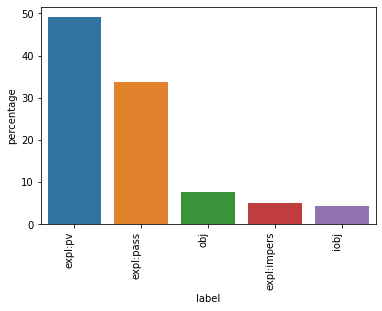

In [13]:
get_class_dist(se_corpus.se_label)

In [11]:
"""
data split
"""
X = se_corpus.tokenized_text
y = se_corpus.se_label

# Split into train+val and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2022)


In [14]:
"""
store value counts for making weighted data sets
"""
y_train_counter = dict(y_train.value_counts())

In [15]:
label_encoder = preprocessing.LabelEncoder()
vectorizer = CountVectorizer()

X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()

pool_vectorized = vectorizer.transform(pool.text).toarray()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


In [16]:
class ClassifierDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)


In [17]:
class PoolDataset(Dataset):
    def __init__(self, X_data):
        self.X_data = X_data

    def __getitem__(self, index):
        return self.X_data[index]

    def __len__(self):
        return len(self.X_data)

In [18]:
"""
convert data splits into Datasets
"""
train_set = ClassifierDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).long())
test_set = ClassifierDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

pool_set = PoolDataset(torch.from_numpy(pool_vectorized).float())

In [19]:
"""
assign bigger weight to less frequent labels
"""
target_list = torch.tensor([target for _, target in train_set])
class_count = [label for label in y_train_counter.values()]
class_weight = 1./torch.tensor(class_count, dtype=torch.float)
print('label distribution: ', y_train_counter.items(), '\nassigned weights: ', class_weight)

label distribution:  dict_items([('expl:pv', 1669), ('expl:pass', 1147), ('obj', 258), ('expl:impers', 174), ('iobj', 150)]) 
assigned weights:  tensor([0.0006, 0.0009, 0.0039, 0.0057, 0.0067])


In [20]:
"""
assign weight to each sample in the train set
"""
class_weight_all = class_weight[target_list]
weighted_sampler = WeightedRandomSampler(weights=class_weight_all, num_samples=len(class_weight_all), replacement=True)

In [21]:
"""
convert Datasets into weighted DataLoader objects
"""
train_loader = DataLoader(dataset=train_set, batch_size=64, sampler=weighted_sampler)
test_loader = DataLoader(dataset=test_set, batch_size=32)

In [25]:
"""
LSTM need 3-D input: determine shape and reshape
"""
train_features, train_labels = next(iter(train_loader))
print(f"Features batch shape: {train_features.size()}")
print(f"Labelss batch shape: {train_labels.size()}")

#reshaping to rows, timestamps, features
train_features = torch.reshape(train_features,   (train_features.shape[0], 1,train_features.shape[1]))
print(f"\nReshaped feature batch shape: {train_features.size()}")

Features batch shape: torch.Size([64, 17200])
Labelss batch shape: torch.Size([64])

Reshaped feature batch shape: torch.Size([64, 1, 17200])


In [21]:
test_features, test_labels = next(iter(test_loader))
test_features = torch.reshape(test_features,   (test_features.shape[0], 1,test_features.shape[1]))

In [22]:
X_pool = pool_set.X_data
X_pool = torch.reshape(X_pool,   (X_pool.shape[0], 1, X_pool.shape[1]))
X_pool = X_pool.detach().cpu().numpy()

## 4) Model

In [22]:
class LSTMModel(nn.Module):
    def __init__(self,):
        super(LSTMModel, self).__init__()
        self.hidden_dim = 64
        self.layer_dim = 1
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(16325, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 5)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [18]:
"""
skorch library creates sklearn classifier from torch neural net
"""
batch_size = 64
n_iters = 1000
epochs = int(n_iters/(len(train_set)/ batch_size))

# create the classifier
device = "cuda" if torch.cuda.is_available() else "cpu"
print('using: ', device)

# Callbacks: print accuracy when model is fitted
acc = EpochScoring(scoring='accuracy', on_train=False,
                         name='accuracy', lower_is_better=False)

f1 = EpochScoring(scoring='f1', on_train=False,
                         name='f1-score', lower_is_better=False)

callbacks = [acc, f1]

classifier = NeuralNetClassifier(module=LSTMModel,
                                 batch_size=64,
                                 max_epochs= epochs,
                                 criterion=nn.CrossEntropyLoss,
                                 optimizer=torch.optim.SGD,
                                 lr=0.1,
                                 train_split=None,
                                 callbacks=callbacks,
                                 #callbacks__train_loss=None,
                                 verbose=1,
                                 device=device)

using:  cpu


In [23]:
classifier.fit(train_features, train_labels)

  epoch    train_acc    train_loss     dur
-------  -----------  ------------  ------
      1       0.0312        1.6198  0.0331
      2       0.3125        1.5885  0.0278
      3       0.5625        1.5591  0.0221
      4       0.6094        1.5314  0.0210
      5       0.6094        1.5054  0.0230
      6       0.6094        1.4810  0.0216
      7       0.6094        1.4581  0.0237
      8       0.6094        1.4366  0.0213
      9       0.6094        1.4164  0.0226
     10       0.6094        1.3976  0.0215
     11       0.6094        1.3800  0.0214
     12       0.6094        1.3635  0.0218
     13       0.6094        1.3481  0.0235
     14       0.6094        1.3338  0.0208
     15       0.6094        1.3204  0.0235
     16       0.6094        1.3079  0.0216
     17       0.6094        1.2963  0.0224
     18       0.6094        1.2855  0.0223
     19       0.6094        1.2755  0.0226
     20       0.6094        1.2661  0.0233


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LSTMModel(
    (lstm): LSTM(16325, 64, batch_first=True)
    (fc): Linear(in_features=64, out_features=5, bias=True)
  ),
)

In [ ]:
targets = label_encoder.classes_

y_pred_test = classifier.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=targets, zero_division=0))

## 3) Active Learner

In [24]:
"""
Initialize the ActiveLearner with the fitted classifier
"""
# no training arguments because classifier is already fitted
learner = ActiveLearner(estimator=classifier,
                        query_strategy=uncertainty_sampling
)

In [25]:
n_instances = 3
# n_instances = 20
accuracies = [learner.score(X_test, y_test)] # append first accuracy without learning
pool_sent_list= list() # store annotated sentences and the labels
pool_label_list= list()

### Loop
- stops after 20 iterations
- prompt sentence

Problem: if annotation is 'None' (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no suited programmatical way to differentiate btw. 'pase' and 'siéntese'.

In [1]:
number_of_loops = 3

In [26]:
for i in range(number_of_loops):# annotate 10 times 20 instances

    # query new instances
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    predicted_proba = get_learners_preds(learner.predict_proba(X_pool[query_idx]))
    sentences = pool.text.iloc[query_idx]

    # annotate the queried instances
    annotation = list()
    counter = 0
    for sent, proba in zip(sentences, predicted_proba):
        counter += 1
        sorted_proba = sorted(proba.items(), key=lambda kv: kv[1], reverse=True)
        prompt = '\n'+'loop: '+str(i+1)+'\n'+'sentence: '+str(counter)+'\n'+'The learners predictions are:'+'\n'+str(sorted_proba)+'\n\n'+sent+'\n'
        label = str(input(prompt))
        annotation.append(label)

    # keep track of annotations
    sent_list = sentences.to_list()
    pool_sent_list.append(sent_list)
    pool_label_list.append(annotation)

    # filter out sentences that were assigned 'None'; the learner should not see them
    if 'None' in annotation:
        print('Note: you either discarded samples or did not annotate all samples')
        discarded_idxs=[idx for idx, sample in enumerate(annotation) if sample == 'None'] # TODO
        discarded_idxs = sorted(discarded_idxs, reverse=True)
        for index in discarded_idxs:
            query_inst = np.delete(query_inst, index, axis=0)
        annotation = list(filter('None'.__ne__, annotation))


    # teach the learner
    y_pool = label_encoder.transform(annotation)
    learner.teach(query_inst, y_pool)
    accuracies.append(learner.score(X=X_test, y=y_test))

    # delete queried instances from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)

  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/pytorch_active_learning_se_corpus
confirm that annotations on rubrix are done


2022-04-06 17:13:40.686 | WARNING  | rubrix.client.rubrix_client:load:310 - The argument 'as_pandas' in `rb.load` will be deprecated in the future, and we will always return a `Dataset`. To emulate the future behavior set `as_pandas=False`. To get a pandas DataFrame, call `Dataset.to_pandas()`


Note: you either discarded samples or did not annotate all samples
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_acc    train_loss     dur
-------  -----------  ------------  ------
      1       0.1111        1.6212  0.0151
      2       0.2222        1.5928  0.0186
      3       0.5556        1.5656  0.0125
      4       0.6667        1.5395  0.0120
      5       0.6667        1.5146  0.0146
      6       0.5556        1.4907  0.0124
      7       0.5556        1.4678  0.0153
      8       0.5556        1.4459  0.0145
      9       0.5556        1.4249  0.0137
     10       0.5556        1.4047  0.0132
     11       0.5556        1.3854  0.0133
     12       0.5556        1.3668  0.0139
     13       0.5556        1.3489  0.0160
     14       0.5556        1.3317  0.0138
     15       0.5556        1.3151  0.0140
     16       0.5556        1.2991  0.0128
     17       0.5556        1.2837  0.0136
     18       0.5556        1.2688  0.

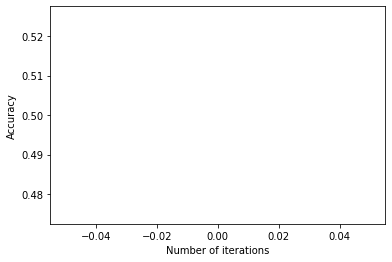

In [27]:
# plot learning curve
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(number_of_loops+1), accuracies)
    plt.scatter(range(number_of_loops+1), accuracies)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [28]:
max(accuracies)

0.5

In [ ]:
# create df from annotations
sent_flattened = get_flattened_list(pool_sent_list)
label_flattened = get_flattened_list(pool_label_list)

labeled_pool = pd.DataFrame(list(zip(sent_flattened, label_flattened)),
               columns =['text', 'se_label'])
print(labeled_pool.shape)
print(labeled_pool.head())

In [ ]:
# save labeled pool
labeled_pool.to_csv('task_data/es_pytorch_annotations.txt', header=None, index=False,  sep='\t')